Important: The cells must be run from top to bottom sequentially.

It is necessary to create a folder ”ml-25m” in the same directory as the
ipynb file, and the ”ml-25m” folder should contain a file ratings.csv, which are
the ratings from MovieLens.

# Loading MovieLens data

ratingsS would be the final 3000x3000 data for our analysis


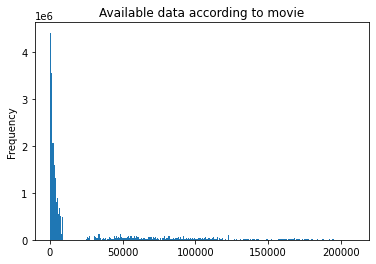

Unique users:  3000
Unique movies:  3000
Entries:  3056972
Ratio:  0.33966355555555555


,userId,movieId,rating,timestamp,uid_matrix,mid_matrix
23893,187,1,3.5,1277374478,0,0
51820,426,1,2.5,1452025761,1,0
68417,548,1,4.5,1431644949,2,0
81298,626,1,4.5,1136304145,3,0
99605,757,1,3.0,1184013452,4,0
...,...,...,...,...,...,...
24884961,161826,1483,3.0,1275237465,2993,641
24899629,161928,1483,2.5,1426701876,2994,641
24914705,162047,1483,3.0,1459091598,2995,641
24950248,162271,1483,2.0,1180311050,2996,641


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load all data from MovieLens
def load_data():
    global genome_scores,genome_tags,links,movies,ratings,tags,data_initialized
    if 'data_initialized' not in globals():
        ratings = pd.read_csv("ml-25m/ratings.csv")
        data_initialized = True

# sample the dataframe by key, where we keep only the data with values of the column key
# with the largest occurences in the whole data frame
def filter_largest_occurences(dataframe, key, count):
    df2 = dataframe.groupby(by = key).count()
    largest = df2.nlargest(count, list(df2.columns)[0])
    largest = largest.index.values
    return dataframe[ dataframe[key].isin(largest) ]

# print the unique number of users, movies, total entries, and the
# entries / no.users * no.movies ratio
def print_data_info(dataframe):
    print("Unique users: ", len(dataframe["userId"].unique()))
    print("Unique movies: ", len(dataframe["movieId"].unique()))
    print("Entries: ", len(dataframe))
    print("Ratio: ", len(dataframe) / (len(dataframe["userId"].unique()) * len(dataframe["movieId"].unique())))

load_data()

# mplot = ratingsS.plot(kind = 'scatter', x = "userId", y = "movieId")
# plt.show()

mplot = ratings['movieId'].plot.hist(bins = 300)
plt.title("Available data according to movie")
plt.show()

# find largest 10000 movies
ratingsS = filter_largest_occurences(ratings, "movieId", 10000)
# find largest 10000 movie watchers
ratingsS = filter_largest_occurences(ratingsS, "userId", 10000)

# further restrict to 3000x3000
ratingsS = filter_largest_occurences(ratingsS, "movieId", 3000)
ratingsS = filter_largest_occurences(ratingsS, "userId", 3000)

# obtain a bijection of userId with the matrix entry, and do the same for movieId.
users = ratingsS["userId"].unique()
movies = ratingsS["movieId"].unique()
users.sort()
movies.sort()

users_lookup = pd.DataFrame(data = np.array([users, np.arange(len(users))]).transpose(), columns = ["userId", "uid_matrix"])
movies_lookup = pd.DataFrame(data = np.array([movies, np.arange(len(movies))]).transpose(), columns = ["movieId", "mid_matrix"])

# join to obtain list of locations
ratingsS = ratingsS.join(users_lookup.set_index('userId'), how="inner", on="userId")\
    .join(movies_lookup.set_index('movieId'), how='inner', on="movieId")
print_data_info(ratingsS)

display(ratingsS)

# ratings[["userId", "movieId"]]

# Partition into 10 random subsets for cross-validation

In [3]:
import math

# basically, first permute the ratings, and then divide into equally sized partitions.
def generate_random_subsets(divisions = 10):
    while True:
        # permute the ratings here
        ratingsPerm = ratingsS.copy()
        ratingsPerm = ratingsPerm.sample(frac=1)
        total_entries = len(ratingsPerm)
        
        # divide into partitions here
        part_size = int(math.floor(total_entries / (divisions+0.0)))
        ratingsSubsample = []
        ratingsSubsamplePivot = []
        enough_user_movies = True

        for k in range(divisions):
            start_range = k * part_size
            end_range = (k+1) * part_size
            subsample = ratingsPerm.iloc[start_range:end_range]
            if (len(subsample["userId"].unique()) < len(ratingsS["userId"].unique())) or \
            (len(subsample["movieId"].unique()) < len(ratingsS["movieId"].unique())):
                enough_user_movies = False
                break

            ratingsSubsample.append(subsample)
        
        # if one of the partitions happen to have less than 3000 users or movies, we repeat the whole process
        if not enough_user_movies:
            continue

        for k in range(divisions):
            subsample = ratingsSubsample[k]
            df_train_subsample = subsample.pivot(index = "userId", columns = "movieId", values = "rating")
            ratingsSubsamplePivot.append(df_train_subsample)
        return ratingsSubsample, ratingsSubsamplePivot

divisions = 10
ratingsSubsample, ratingsSubsamplePivot = generate_random_subsets(divisions)
for k in range(divisions):
    print("------------------ Data",k,"------------------")
    print_data_info(ratingsSubsample[k])

------------------ Data 0 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 1 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 2 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 3 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 4 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 5 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 6 ------------------
Unique users:  3000
Unique movies:  3000
Entries:  305697
Ratio:  0.033966333333333334
------------------ Data 7 ------------------
Unique users:  3000
Unique movi

# Use the SVT algorithm for MovieLens data
### If the SVT algorithm does not converge (exception happens), use step_size=1.99 for safety

-------------------------- Running with data  0  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1919.1020035422819     nuc: 0.0      last rank: 0
fro:  1919.1020035422819     nuc: 0.0      last rank: 0
fro:  1919.1020035422819     nuc: 0.0      last rank: 0
fro:  1919.1020035422819     nuc: 0.0      last rank: 0
fro:  1919.1020035422819     nuc: 0.0      last rank: 0
fro:  1919.1020035422819     nuc: 0.0      last rank: 0
fro:  1919.1020035422819     nuc: 0.0      last rank: 0
fro:  1919.1020035422819     nuc: 0.0      last rank: 0
fro:  1919.1020035422819     nuc: 0.0      last rank: 0
fro:  1919.1020035422819     nuc: 0.0      last rank: 0
fro:  1578.8820617904034     nuc: 1637.4770658896014      last rank: 1
fro:  1346.855196113439     nuc: 2881.789799918064      last rank: 1
fro:  1192.9748730880142     nuc: 3814.724032444119      last rank: 1
fro:  1088.489078640645     nuc: 4524.739822246873      last rank: 1
fro:  1014.181208699235     nuc: 5075.557594523172

fro:  423.90413346359264     nuc: 9641.892988052197      last rank: 3
fro:  422.90854057657816     nuc: 9641.466614893758      last rank: 3
fro:  422.1384411307634     nuc: 9640.18514905039      last rank: 3
fro:  421.5229303314079     nuc: 9638.391690730139      last rank: 3
fro:  421.0153020613793     nuc: 9636.331853142627      last rank: 3
fro:  420.5845193948713     nuc: 9634.178694188362      last rank: 3
fro:  420.2097181813084     nuc: 9632.051629599358      last rank: 3
fro:  419.87667237368623     nuc: 9630.030707108403      last rank: 3
fro:  419.57551962334657     nuc: 9628.16732737828      last rank: 3
fro:  419.2992937061544     nuc: 9626.492257859281      last rank: 3
fro:  419.0429730131558     nuc: 9625.0215939452      last rank: 3
fro:  418.80285949695445     nuc: 9623.761170286703      last rank: 3
fro:  418.5761698322392     nuc: 9622.709806711602      last rank: 3
fro:  418.3607634639219     nuc: 9621.861681395741      last rank: 3
fro:  418.15495947600556     nuc:

fro:  267.06907060902944     nuc: 9408.748813944308      last rank: 60
fro:  265.2215033404482     nuc: 9406.156201510417      last rank: 61
fro:  263.4349638264863     nuc: 9403.544283092895      last rank: 62
fro:  261.6097389795573     nuc: 9400.948291216293      last rank: 64
fro:  259.8217411841394     nuc: 9398.342033714376      last rank: 65
fro:  258.0872540873198     nuc: 9395.741025357878      last rank: 65
fro:  256.2283204132469     nuc: 9393.155401677923      last rank: 67
fro:  254.5289170066753     nuc: 9390.523306304927      last rank: 69
fro:  252.77076628811352     nuc: 9387.948988108601      last rank: 69
fro:  251.10676462966018     nuc: 9385.365405887489      last rank: 71
fro:  249.4293592411293     nuc: 9382.822354114709      last rank: 71
fro:  247.90299102732524     nuc: 9380.291988620873      last rank: 72
fro:  246.4113805189332     nuc: 9377.829934396836      last rank: 73
fro:  244.8495977056146     nuc: 9375.404516650986      last rank: 74
fro:  243.393855

fro:  136.676384246028     nuc: 9193.750120549215      last rank: 151
fro:  135.93609143463127     nuc: 9192.650742025155      last rank: 151
fro:  135.25974203897024     nuc: 9191.516315243429      last rank: 151
fro:  134.5825775044785     nuc: 9190.415678572248      last rank: 152
fro:  133.91453341936565     nuc: 9189.318856541631      last rank: 153
fro:  133.2327801291218     nuc: 9188.230097952106      last rank: 153
fro:  132.59143103065094     nuc: 9187.13946590371      last rank: 154
fro:  131.8939663692359     nuc: 9186.076465053276      last rank: 155
fro:  131.17620072242212     nuc: 9184.991103363529      last rank: 156
fro:  130.51708238031767     nuc: 9183.896096823402      last rank: 156
fro:  129.89280351127746     nuc: 9182.837143014036      last rank: 157
fro:  129.2603073729833     nuc: 9181.805615777695      last rank: 157
fro:  128.66703837311726     nuc: 9180.774802071184      last rank: 157
fro:  128.04492011939828     nuc: 9179.773645722533      last rank: 158

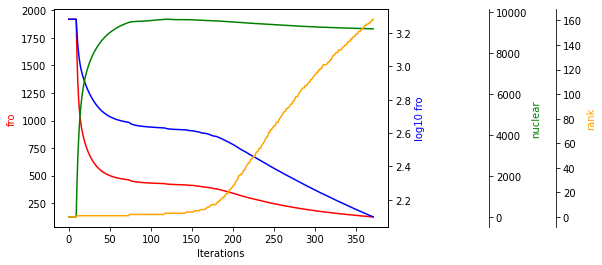

time elasped:  848  s
-------------------------- Validating the training with data  0  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  229025  Ratio:  0.7491895569796236  Off by one:  304630  Ratio:  0.996509615730609  L2: 0.07371904903673013
Validation with other samples:
Sample size:  2751273  Correct:  713284  Ratio:  0.25925598804626077  Off by one:  1821198  Ratio:  0.6619473967141756  L2: 0.24300401647843456
-------------------------- Running with data  1  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1921.7536262486926     nuc: 0.0      last rank: 0
fro:  1921.7536262486926     nuc: 0.0      last rank: 0
fro:  1921.7536262486926     nuc: 0.0      last rank: 0
fro:  1921.7536262486926     nuc: 0.0      last rank: 0
fro:  1921.7536262486926     nuc: 0.0      last rank: 0
fro:  1921.7536262486926     nuc: 0.0      last rank: 0
fro:  1921.7536262486926     nuc: 0.0      last rank: 0
fro:  1921.7536262486926     nuc: 0

fro:  427.1200400159337     nuc: 9636.51631332875      last rank: 2
fro:  426.8783063183063     nuc: 9639.969493125613      last rank: 2
fro:  425.3736641102505     nuc: 9643.416441599613      last rank: 3
fro:  423.7708569016467     nuc: 9645.320628036916      last rank: 3
fro:  422.5823103451984     nuc: 9645.529208572603      last rank: 3
fro:  421.6736058279618     nuc: 9644.615912250141      last rank: 3
fro:  420.9564719982747     nuc: 9642.998765665066      last rank: 3
fro:  420.372647366201     nuc: 9640.978917487628      last rank: 3
fro:  419.88337297952137     nuc: 9638.77032853973      last rank: 3
fro:  419.4625920673916     nuc: 9636.52233774025      last rank: 3
fro:  419.09255947855917     nuc: 9634.33671965732      last rank: 3
fro:  418.76100599430924     nuc: 9632.280513064208      last rank: 3
fro:  418.45930213328165     nuc: 9630.395621980795      last rank: 3
fro:  418.1812637908894     nuc: 9628.705966080965      last rank: 3
fro:  417.92237050346995     nuc: 9

fro:  277.2271493694189     nuc: 9427.431707048512      last rank: 54
fro:  275.44618355054956     nuc: 9424.939522099416      last rank: 56
fro:  273.48766030193406     nuc: 9422.456483504928      last rank: 57
fro:  271.5903316650321     nuc: 9419.901021269234      last rank: 58
fro:  269.8721927371529     nuc: 9417.339867624341      last rank: 59
fro:  267.98261936463587     nuc: 9414.843414553816      last rank: 60
fro:  266.25129507131436     nuc: 9412.299707185146      last rank: 61
fro:  264.648929408142     nuc: 9409.798724881697      last rank: 61
fro:  263.00901671079544     nuc: 9407.358397571377      last rank: 62
fro:  261.5519238345059     nuc: 9404.939950519034      last rank: 62
fro:  259.83715861390476     nuc: 9402.606434989215      last rank: 64
fro:  258.2765635113543     nuc: 9400.205381731022      last rank: 64
fro:  256.5866093636188     nuc: 9397.832202497713      last rank: 66
fro:  254.85323839275458     nuc: 9395.418355856411      last rank: 67
fro:  253.2083

fro:  140.55953662767587     nuc: 9210.300749838254      last rank: 149
fro:  139.81908686107764     nuc: 9209.112352894015      last rank: 149
fro:  139.13860329738955     nuc: 9207.95652796168      last rank: 149
fro:  138.44317153430768     nuc: 9206.842262011913      last rank: 150
fro:  137.77523301214939     nuc: 9205.733000008226      last rank: 150
fro:  137.14588344181868     nuc: 9204.64532931372      last rank: 150
fro:  136.52897575457382     nuc: 9203.58704665957      last rank: 151
fro:  135.86922012787528     nuc: 9202.544589268105      last rank: 152
fro:  135.20644285248594     nuc: 9201.4820328003      last rank: 152
fro:  134.5855240403365     nuc: 9200.41935190912      last rank: 152
fro:  133.93556075014126     nuc: 9199.385187554457      last rank: 153
fro:  133.31587295572794     nuc: 9198.341465235168      last rank: 153
fro:  132.66750133239682     nuc: 9197.317870759383      last rank: 154
fro:  132.05010681219292     nuc: 9196.284851302793      last rank: 155

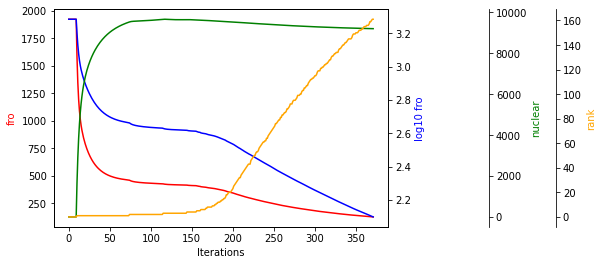

time elasped:  846  s
-------------------------- Validating the training with data  1  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  229111  Ratio:  0.749470881297494  Off by one:  304621  Ratio:  0.9964801748136226  L2: 0.07356858006807651
Validation with other samples:
Sample size:  2751273  Correct:  715054  Ratio:  0.2598993266026309  Off by one:  1821671  Ratio:  0.6621193171306519  L2: 0.2432280478986117
-------------------------- Running with data  2  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1921.187848701943     nuc: 0.0      last rank: 0
fro:  1921.187848701943     nuc: 0.0      last rank: 0
fro:  1921.187848701943     nuc: 0.0      last rank: 0
fro:  1921.187848701943     nuc: 0.0      last rank: 0
fro:  1921.187848701943     nuc: 0.0      last rank: 0
fro:  1921.187848701943     nuc: 0.0      last rank: 0
fro:  1921.187848701943     nuc: 0.0      last rank: 0
fro:  1921.187848701943     nuc: 0.0      la

fro:  427.698740178221     nuc: 9627.353063220628      last rank: 2
fro:  427.4580124843261     nuc: 9630.887004984372      last rank: 2
fro:  427.2249934671763     nuc: 9634.408604249566      last rank: 2
fro:  425.40063811847796     nuc: 9637.9176636862      last rank: 3
fro:  423.7425715991301     nuc: 9639.667027371634      last rank: 3
fro:  422.54287198115134     nuc: 9639.817125452046      last rank: 3
fro:  421.64651676823985     nuc: 9638.937663032819      last rank: 3
fro:  420.9530748554557     nuc: 9637.438308700672      last rank: 3
fro:  420.39734107939194     nuc: 9635.60956316482      last rank: 3
fro:  419.936751345646     nuc: 9633.653871445913      last rank: 3
fro:  419.5432852770123     nuc: 9631.709135594665      last rank: 3
fro:  419.19828578518786     nuc: 9629.8663662318      last rank: 3
fro:  418.8891528299995     nuc: 9628.182850865134      last rank: 3
fro:  418.607232832782     nuc: 9626.691917232805      last rank: 3
fro:  418.34646793787334     nuc: 962

fro:  276.56659582881593     nuc: 9425.977582940413      last rank: 55
fro:  274.9035684303337     nuc: 9423.211023468863      last rank: 55
fro:  273.3889076954855     nuc: 9420.532685675047      last rank: 56
fro:  271.8588522208971     nuc: 9417.95819352673      last rank: 56
fro:  270.4047362096313     nuc: 9415.42573630618      last rank: 57
fro:  268.7003890597416     nuc: 9412.958193053775      last rank: 59
fro:  266.75524603898214     nuc: 9410.42049047213      last rank: 61
fro:  264.91470251830947     nuc: 9407.753142444726      last rank: 61
fro:  263.2342338540777     nuc: 9405.068818142117      last rank: 62
fro:  261.4636843378399     nuc: 9402.448728740528      last rank: 64
fro:  259.69137774398064     nuc: 9399.817332204875      last rank: 65
fro:  258.0069029987006     nuc: 9397.183534962664      last rank: 65
fro:  256.5223488839206     nuc: 9394.59425471865      last rank: 66
fro:  255.0435507717736     nuc: 9392.11371405932      last rank: 66
fro:  253.31773634316

fro:  141.44715400113935     nuc: 9207.078782371318      last rank: 146
fro:  140.68702847600548     nuc: 9205.894821382346      last rank: 148
fro:  139.92012282045116     nuc: 9204.709407809449      last rank: 148
fro:  139.22246970780085     nuc: 9203.521491282143      last rank: 148
fro:  138.51805824746424     nuc: 9202.374411040331      last rank: 149
fro:  137.84233166475266     nuc: 9201.233891781558      last rank: 149
fro:  137.16298529479744     nuc: 9200.115203941867      last rank: 150
fro:  136.50586110696153     nuc: 9199.002564685095      last rank: 150
fro:  135.82619053748223     nuc: 9197.907892152081      last rank: 151
fro:  135.1870825291144     nuc: 9196.81260949645      last rank: 151
fro:  134.55091230336913     nuc: 9195.749253399863      last rank: 152
fro:  133.84628499734575     nuc: 9194.699517768662      last rank: 153
fro:  133.19377085328148     nuc: 9193.618265172012      last rank: 153
fro:  132.5450194328955     nuc: 9192.567339283312      last rank:

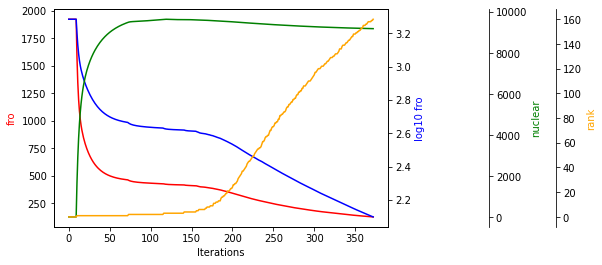

time elasped:  841  s
-------------------------- Validating the training with data  2  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228705  Ratio:  0.7481427688201062  Off by one:  304704  Ratio:  0.9967516854924975  L2: 0.07365878517289708
Validation with other samples:
Sample size:  2751273  Correct:  715828  Ratio:  0.2601806509205012  Off by one:  1823013  Ratio:  0.6626070913355381  L2: 0.24278806501558683
-------------------------- Running with data  3  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1919.9988281246424     nuc: 0.0      last rank: 0
fro:  1919.9988281246424     nuc: 0.0      last rank: 0
fro:  1919.9988281246424     nuc: 0.0      last rank: 0
fro:  1919.9988281246424     nuc: 0.0      last rank: 0
fro:  1919.9988281246424     nuc: 0.0      last rank: 0
fro:  1919.9988281246424     nuc: 0.0      last rank: 0
fro:  1919.9988281246424     nuc: 0.0      last rank: 0
fro:  1919.9988281246424     nuc: 0

fro:  427.41184734097345     nuc: 9619.43562774613      last rank: 2
fro:  427.1719218397598     nuc: 9622.918094955665      last rank: 2
fro:  426.9401943506055     nuc: 9626.384631874826      last rank: 2
fro:  426.7164341063613     nuc: 9629.833818541985      last rank: 2
fro:  425.76065641932007     nuc: 9633.264497436692      last rank: 3
fro:  424.06591439795767     nuc: 9635.79534143032      last rank: 3
fro:  422.8192699242951     nuc: 9636.451618442858      last rank: 3
fro:  421.8735498169088     nuc: 9635.841516351964      last rank: 3
fro:  421.13246336170164     nuc: 9634.41161690377      last rank: 3
fro:  420.53274560684133     nuc: 9632.486597244413      last rank: 3
fro:  420.03253326309834     nuc: 9630.29971091049      last rank: 3
fro:  419.6038515441932     nuc: 9628.016049538983      last rank: 3
fro:  419.2277740899986     nuc: 9625.750201417522      last rank: 3
fro:  418.8913061905841     nuc: 9623.579592031147      last rank: 3
fro:  418.58537388478413     nuc

fro:  279.666302608199     nuc: 9419.243783489987      last rank: 53
fro:  277.9450096985296     nuc: 9416.48761698102      last rank: 54
fro:  276.0841363373196     nuc: 9413.800910324502      last rank: 55
fro:  274.0361538032938     nuc: 9411.088066367956      last rank: 57
fro:  272.142242020361     nuc: 9408.289196573518      last rank: 57
fro:  270.55156330528     nuc: 9405.503878301326      last rank: 58
fro:  268.9117623066415     nuc: 9402.846552958235      last rank: 58
fro:  267.31112483069467     nuc: 9400.224545525853      last rank: 59
fro:  265.61569867458945     nuc: 9397.65306227778      last rank: 60
fro:  263.85814665006797     nuc: 9395.075746175611      last rank: 62
fro:  261.910208106276     nuc: 9392.495391172764      last rank: 63
fro:  260.0594902837425     nuc: 9389.842911221604      last rank: 64
fro:  258.3931698704332     nuc: 9387.202886455561      last rank: 64
fro:  256.69259287533646     nuc: 9384.642840696757      last rank: 66
fro:  255.0436036283641

fro:  141.3629628026325     nuc: 9198.192787255233      last rank: 146
fro:  140.6947147493388     nuc: 9197.026405539218      last rank: 147
fro:  139.99267991268297     nuc: 9195.890652088168      last rank: 147
fro:  139.33470593158586     nuc: 9194.741609034812      last rank: 148
fro:  138.64050284718263     nuc: 9193.620566261845      last rank: 148
fro:  137.99228466588818     nuc: 9192.48552051929      last rank: 148
fro:  137.34685298181734     nuc: 9191.379110165282      last rank: 149
fro:  136.62997399727706     nuc: 9190.283575769288      last rank: 150
fro:  135.91563599698085     nuc: 9189.155771778464      last rank: 151
fro:  135.21674216407956     nuc: 9188.033256720191      last rank: 152
fro:  134.53070464315326     nuc: 9186.922978318362      last rank: 152
fro:  133.87334388563724     nuc: 9185.823766626767      last rank: 153
fro:  133.21239654381483     nuc: 9184.749759472019      last rank: 153
fro:  132.53342372841269     nuc: 9183.682482363783      last rank:

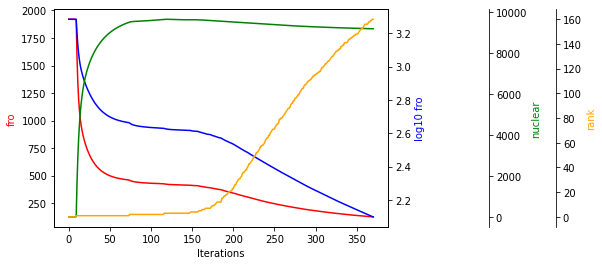

time elasped:  834  s
-------------------------- Validating the training with data  3  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228421  Ratio:  0.7472137443285345  Off by one:  304651  Ratio:  0.9965783112035774  L2: 0.07390471892857751
Validation with other samples:
Sample size:  2751273  Correct:  714456  Ratio:  0.2596819726722866  Off by one:  1820838  Ratio:  0.6618165481942359  L2: 0.24314420735184678
-------------------------- Running with data  4  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1921.170541622997     nuc: 0.0      last rank: 0
fro:  1921.170541622997     nuc: 0.0      last rank: 0
fro:  1921.170541622997     nuc: 0.0      last rank: 0
fro:  1921.170541622997     nuc: 0.0      last rank: 0
fro:  1921.170541622997     nuc: 0.0      last rank: 0
fro:  1921.170541622997     nuc: 0.0      last rank: 0
fro:  1921.170541622997     nuc: 0.0      last rank: 0
fro:  1921.170541622997     nuc: 0.0      

fro:  426.8896585070083     nuc: 9622.319832009205      last rank: 2
fro:  426.64642022897243     nuc: 9625.859859220393      last rank: 2
fro:  426.38738100813566     nuc: 9629.385524841087      last rank: 3
fro:  424.34610483809684     nuc: 9632.870185765187      last rank: 3
fro:  422.86753544126236     nuc: 9634.169199210311      last rank: 3
fro:  421.76533093464593     nuc: 9633.985603076235      last rank: 3
fro:  420.9174733998233     nuc: 9632.835570470095      last rank: 3
fro:  420.2438900040991     nuc: 9631.094224650173      last rank: 3
fro:  419.6917555146837     nuc: 9629.030883466621      last rank: 3
fro:  419.22593678141317     nuc: 9626.835994565547      last rank: 3
fro:  418.8228146766903     nuc: 9624.641601208714      last rank: 3
fro:  418.4662985140862     nuc: 9622.536810509839      last rank: 3
fro:  418.145253862053     nuc: 9620.579426196626      last rank: 3
fro:  417.8518383042763     nuc: 9618.804654134474      last rank: 3
fro:  417.5804198820372     n

fro:  279.0520178323342     nuc: 9425.049848498635      last rank: 52
fro:  277.1346848847702     nuc: 9422.401994215303      last rank: 54
fro:  275.26208564161414     nuc: 9419.675860368432      last rank: 55
fro:  273.3179928598296     nuc: 9416.931474318491      last rank: 57
fro:  271.35066564933834     nuc: 9414.16014478727      last rank: 57
fro:  269.7305327443405     nuc: 9411.35662681823      last rank: 57
fro:  268.0892063222881     nuc: 9408.676774507225      last rank: 59
fro:  266.17682136995336     nuc: 9406.046555923309      last rank: 60
fro:  264.27737833848795     nuc: 9403.335263990448      last rank: 61
fro:  262.60847575510854     nuc: 9400.601165187407      last rank: 62
fro:  260.843916999034     nuc: 9397.948804960732      last rank: 63
fro:  258.9832286325952     nuc: 9395.288490051611      last rank: 65
fro:  257.299737278663     nuc: 9392.59391612505      last rank: 65
fro:  255.82933957420408     nuc: 9389.961400933003      last rank: 66
fro:  254.126875384

fro:  141.0599894303028     nuc: 9199.599263552449      last rank: 147
fro:  140.37536291114807     nuc: 9198.419375534319      last rank: 147
fro:  139.66946505409965     nuc: 9197.277541102332      last rank: 149
fro:  138.9309164085938     nuc: 9196.135856683184      last rank: 149
fro:  138.2519525569155     nuc: 9194.982695126731      last rank: 149
fro:  137.59013496119644     nuc: 9193.867403026761      last rank: 151
fro:  136.8526814047029     nuc: 9192.770145502505      last rank: 151
fro:  136.1465536451033     nuc: 9191.631961864296      last rank: 152
fro:  135.4493651198263     nuc: 9190.51330868787      last rank: 153
fro:  134.7440479503314     nuc: 9189.403468719855      last rank: 153
fro:  134.03572437464922     nuc: 9188.292847421653      last rank: 154
fro:  133.37796024802498     nuc: 9187.185859601785      last rank: 154
fro:  132.69591563174507     nuc: 9186.112911277709      last rank: 155
fro:  132.0165187655479     nuc: 9185.035181795207      last rank: 156
f

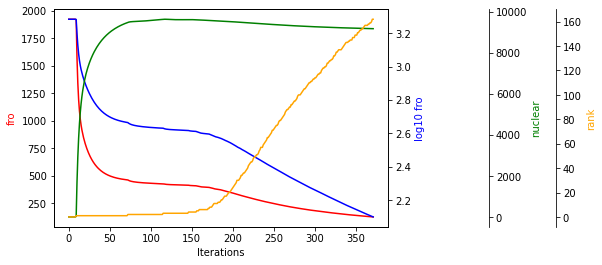

time elasped:  849  s
-------------------------- Validating the training with data  4  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  229066  Ratio:  0.7493236767125618  Off by one:  304652  Ratio:  0.9965815824165759  L2: 0.07354211432376556
Validation with other samples:
Sample size:  2751273  Correct:  716551  Ratio:  0.26044343836471334  Off by one:  1825025  Ratio:  0.6633383891747565  L2: 0.24271637076532412
-------------------------- Running with data  5  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1920.4110888036446     nuc: 0.0      last rank: 0
fro:  1920.4110888036446     nuc: 0.0      last rank: 0
fro:  1920.4110888036446     nuc: 0.0      last rank: 0
fro:  1920.4110888036446     nuc: 0.0      last rank: 0
fro:  1920.4110888036446     nuc: 0.0      last rank: 0
fro:  1920.4110888036446     nuc: 0.0      last rank: 0
fro:  1920.4110888036446     nuc: 0.0      last rank: 0
fro:  1920.4110888036446     nuc: 

fro:  427.39771629756245     nuc: 9620.251820014299      last rank: 2
fro:  427.1476784259886     nuc: 9623.7810705115      last rank: 2
fro:  426.90588353391456     nuc: 9627.297495015042      last rank: 2
fro:  426.672129297743     nuc: 9630.800151280531      last rank: 2
fro:  426.44623153828195     nuc: 9634.288324582973      last rank: 2
fro:  426.13126915199257     nuc: 9637.761515404327      last rank: 3
fro:  424.0430516134554     nuc: 9641.120461700095      last rank: 3
fro:  422.5432027155763     nuc: 9642.391640856938      last rank: 3
fro:  421.43787980868353     nuc: 9642.256731353515      last rank: 3
fro:  420.59898940906794     nuc: 9641.2148113607      last rank: 3
fro:  419.9419307705457     nuc: 9639.627204595923      last rank: 3
fro:  419.41067481636946     nuc: 9637.752030497257      last rank: 3
fro:  418.9679035163476     nuc: 9635.770630092808      last rank: 3
fro:  418.58855172660117     nuc: 9633.80764778359      last rank: 3
fro:  418.25559868142045     nuc

fro:  279.5638903263627     nuc: 9424.31985593601      last rank: 54
fro:  277.78376081938205     nuc: 9421.5998914167      last rank: 55
fro:  275.9818470053871     nuc: 9418.882352276505      last rank: 56
fro:  274.1973487815517     nuc: 9416.165896874561      last rank: 56
fro:  272.4469964822049     nuc: 9413.462294749817      last rank: 57
fro:  270.8383209252618     nuc: 9410.766423687219      last rank: 58
fro:  269.2263619468371     nuc: 9408.139019373542      last rank: 59
fro:  267.56719631327576     nuc: 9405.542814664313      last rank: 60
fro:  265.79085627411274     nuc: 9402.95319130738      last rank: 61
fro:  264.16435355083274     nuc: 9400.331557465626      last rank: 62
fro:  262.5057520872679     nuc: 9397.75613151641      last rank: 62
fro:  260.9080958772715     nuc: 9395.194171794155      last rank: 63
fro:  259.2465908978908     nuc: 9392.677783537521      last rank: 64
fro:  257.56291729884373     nuc: 9390.161356079981      last rank: 65
fro:  255.9867309900

fro:  142.23555798615203     nuc: 9200.703445930121      last rank: 145
fro:  141.52410686640957     nuc: 9199.577961006733      last rank: 146
fro:  140.75247921980957     nuc: 9198.449442763096      last rank: 148
fro:  139.96438031150822     nuc: 9197.295222654811      last rank: 149
fro:  139.20240646468832     nuc: 9196.134138576286      last rank: 149
fro:  138.5062675585611     nuc: 9194.986582704078      last rank: 149
fro:  137.85266940879436     nuc: 9193.879563021565      last rank: 149
fro:  137.17218433927752     nuc: 9192.804903867775      last rank: 150
fro:  136.47658811826955     nuc: 9191.726811109842      last rank: 151
fro:  135.80553989886582     nuc: 9190.647545649626      last rank: 152
fro:  135.11660537987842     nuc: 9189.586239833403      last rank: 152
fro:  134.43558089409117     nuc: 9188.521531604278      last rank: 154
fro:  133.71042737349933     nuc: 9187.467994324881      last rank: 154
fro:  133.03910700623663     nuc: 9186.393987186766      last ran

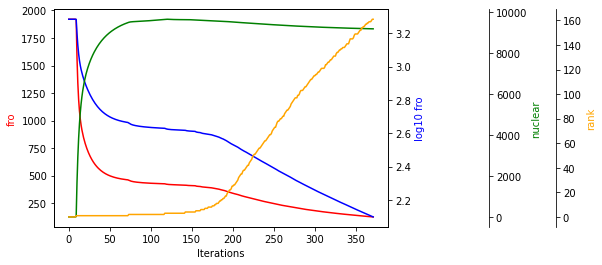

time elasped:  833  s
-------------------------- Validating the training with data  5  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228635  Ratio:  0.7479137839102118  Off by one:  304643  Ratio:  0.9965521414995895  L2: 0.0738071522870999
Validation with other samples:
Sample size:  2751273  Correct:  714406  Ratio:  0.25966379926673944  Off by one:  1820191  Ratio:  0.6615813843264554  L2: 0.24324120923300702
-------------------------- Running with data  6  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1919.7844931137454     nuc: 0.0      last rank: 0
fro:  1919.7844931137454     nuc: 0.0      last rank: 0
fro:  1919.7844931137454     nuc: 0.0      last rank: 0
fro:  1919.7844931137454     nuc: 0.0      last rank: 0
fro:  1919.7844931137454     nuc: 0.0      last rank: 0
fro:  1919.7844931137454     nuc: 0.0      last rank: 0
fro:  1919.7844931137454     nuc: 0.0      last rank: 0
fro:  1919.7844931137454     nuc: 0

fro:  428.1769458028301     nuc: 9620.487277452976      last rank: 2
fro:  427.9316089170624     nuc: 9623.840786052373      last rank: 2
fro:  427.6939971414392     nuc: 9627.184174959119      last rank: 2
fro:  427.4639361464975     nuc: 9630.517001787975      last rank: 2
fro:  426.3825197142724     nuc: 9633.839093508006      last rank: 3
fro:  424.5323608237639     nuc: 9636.219963763291      last rank: 3
fro:  423.18650973705087     nuc: 9636.73987427236      last rank: 3
fro:  422.1789719787036     nuc: 9636.027525821457      last rank: 3
fro:  421.40062028661697     nuc: 9634.540778427738      last rank: 3
fro:  420.77957627395136     nuc: 9632.609066918885      last rank: 3
fro:  420.2682631780893     nuc: 9630.465965738007      last rank: 3
fro:  419.8349471040674     nuc: 9628.274014734125      last rank: 3
fro:  419.4582427302011     nuc: 9626.143525085885      last rank: 3
fro:  419.1235537435647     nuc: 9624.146741212313      last rank: 3
fro:  418.8207667240744     nuc:

fro:  277.2618157330233     nuc: 9415.71298450409      last rank: 56
fro:  275.34320458548274     nuc: 9412.912759557828      last rank: 56
fro:  273.72003896311077     nuc: 9410.116456443862      last rank: 57
fro:  271.9866937823686     nuc: 9407.449676674896      last rank: 58
fro:  270.23465133432154     nuc: 9404.812190230747      last rank: 59
fro:  268.5714163310891     nuc: 9402.183733538084      last rank: 59
fro:  267.0706884977673     nuc: 9399.602012561849      last rank: 60
fro:  265.5226380584399     nuc: 9397.11635515151      last rank: 60
fro:  263.6635248169786     nuc: 9394.651888091517      last rank: 62
fro:  261.85030956830866     nuc: 9392.079833741449      last rank: 63
fro:  260.07430258489495     nuc: 9389.473378261264      last rank: 65
fro:  258.27091561436424     nuc: 9386.85685771083      last rank: 65
fro:  256.502633835255     nuc: 9384.204154918112      last rank: 67
fro:  254.6810504248608     nuc: 9381.553510011658      last rank: 68
fro:  252.86979992

fro:  140.6477799403821     nuc: 9193.796770954996      last rank: 147
fro:  139.9390484246228     nuc: 9192.633926127397      last rank: 147
fro:  139.27797582653594     nuc: 9191.481924747972      last rank: 147
fro:  138.572029746326     nuc: 9190.362975025826      last rank: 149
fro:  137.8547114962466     nuc: 9189.229955502193      last rank: 150
fro:  137.12851684781637     nuc: 9188.0935029223      last rank: 150
fro:  136.4087622736399     nuc: 9186.955843172687      last rank: 151
fro:  135.73333951234954     nuc: 9185.825833807605      last rank: 152
fro:  135.04679660282133     nuc: 9184.726202013291      last rank: 152
fro:  134.39888091497482     nuc: 9183.627383202878      last rank: 153
fro:  133.73014984311385     nuc: 9182.558861909922      last rank: 154
fro:  133.0368231626747     nuc: 9181.487690796588      last rank: 155
fro:  132.34505072826778     nuc: 9180.408731217725      last rank: 155
fro:  131.70807885667568     nuc: 9179.33994807017      last rank: 155
fr

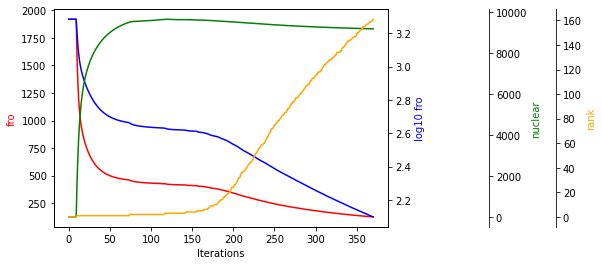

time elasped:  892  s
-------------------------- Validating the training with data  6  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228773  Ratio:  0.7483652113040037  Off by one:  304545  Ratio:  0.9962315626257372  L2: 0.07388588648989605
Validation with other samples:
Sample size:  2751273  Correct:  714059  Ratio:  0.259537675832242  Off by one:  1820869  Ratio:  0.6618278157056752  L2: 0.2433339354793743
-------------------------- Running with data  7  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1920.7145805663058     nuc: 0.0      last rank: 0
fro:  1920.7145805663058     nuc: 0.0      last rank: 0
fro:  1920.7145805663058     nuc: 0.0      last rank: 0
fro:  1920.7145805663058     nuc: 0.0      last rank: 0
fro:  1920.7145805663058     nuc: 0.0      last rank: 0
fro:  1920.7145805663058     nuc: 0.0      last rank: 0
fro:  1920.7145805663058     nuc: 0.0      last rank: 0
fro:  1920.7145805663058     nuc: 0.0

fro:  427.4900222747306     nuc: 9622.791569012436      last rank: 2
fro:  427.2416997353049     nuc: 9626.266539289689      last rank: 2
fro:  425.8686971110083     nuc: 9629.743120596424      last rank: 3
fro:  424.02821839817517     nuc: 9631.99580926412      last rank: 3
fro:  422.6947540817639     nuc: 9632.440053922626      last rank: 3
fro:  421.69882717036916     nuc: 9631.69280931148      last rank: 3
fro:  420.93005794089544     nuc: 9630.201784498895      last rank: 3
fro:  420.31637471518104     nuc: 9628.287946991008      last rank: 3
fro:  419.81044867099587     nuc: 9626.178016632624      last rank: 3
fro:  419.380929360823     nuc: 9624.029131501044      last rank: 3
fro:  419.00681227217996     nuc: 9621.94745368608      last rank: 3
fro:  418.673826381263     nuc: 9620.002122273803      last rank: 3
fro:  418.37211568547275     nuc: 9618.235658731119      last rank: 3
fro:  418.094746853337     nuc: 9616.671683439392      last rank: 3
fro:  417.8367438910018     nuc: 

fro:  278.26283775636773     nuc: 9420.908938180582      last rank: 54
fro:  276.295037763737     nuc: 9418.267171324016      last rank: 55
fro:  274.5685992698112     nuc: 9415.563364799356      last rank: 56
fro:  272.7868543215127     nuc: 9412.927421760523      last rank: 57
fro:  271.0363579413596     nuc: 9410.29673774702      last rank: 57
fro:  269.15406305232625     nuc: 9407.685526522891      last rank: 59
fro:  267.2738685624423     nuc: 9405.032039021262      last rank: 60
fro:  265.5186558743022     nuc: 9402.362427947966      last rank: 61
fro:  263.7614625173293     nuc: 9399.73861656912      last rank: 63
fro:  261.92451133620114     nuc: 9397.134828384053      last rank: 63
fro:  260.3912676013798     nuc: 9394.49852865161      last rank: 63
fro:  258.84839666520463     nuc: 9391.978275948939      last rank: 64
fro:  257.3267479586043     nuc: 9389.504458670857      last rank: 65
fro:  255.69367376902827     nuc: 9387.065458694266      last rank: 66
fro:  254.122203768

fro:  140.8756479790401     nuc: 9198.085488031942      last rank: 146
fro:  140.18540385477928     nuc: 9196.962602348623      last rank: 147
fro:  139.4627429879974     nuc: 9195.84804573606      last rank: 148
fro:  138.74472870036928     nuc: 9194.725683901299      last rank: 149
fro:  138.03760426698366     nuc: 9193.611296935112      last rank: 149
fro:  137.37969787332352     nuc: 9192.507390002      last rank: 149
fro:  136.67132074241545     nuc: 9191.438460045116      last rank: 151
fro:  135.9617512753927     nuc: 9190.355479369005      last rank: 151
fro:  135.30676404171345     nuc: 9189.274580194608      last rank: 151
fro:  134.68700339163806     nuc: 9188.229334954663      last rank: 151
fro:  134.06877490469054     nuc: 9187.21207366819      last rank: 152
fro:  133.43663258245041     nuc: 9186.204851102983      last rank: 152
fro:  132.7505340914044     nuc: 9185.19489502233      last rank: 154
fro:  132.07986633284432     nuc: 9184.164609823558      last rank: 154
fr

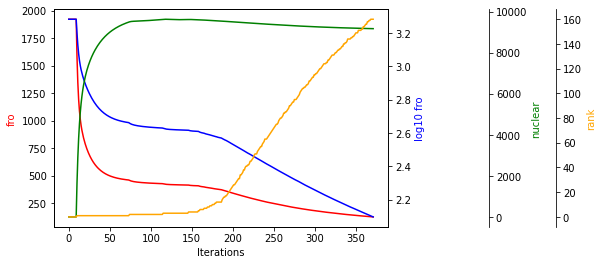

time elasped:  972  s
-------------------------- Validating the training with data  7  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228770  Ratio:  0.7483553976650081  Off by one:  304636  Ratio:  0.9965292430086  L2: 0.07374174777026234
Validation with other samples:
Sample size:  2751273  Correct:  712951  Ratio:  0.25913495316531654  Off by one:  1821447  Ratio:  0.6620379002738005  L2: 0.2432019629879345
-------------------------- Running with data  8  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1919.3220808400033     nuc: 0.0      last rank: 0
fro:  1919.3220808400033     nuc: 0.0      last rank: 0
fro:  1919.3220808400033     nuc: 0.0      last rank: 0
fro:  1919.3220808400033     nuc: 0.0      last rank: 0
fro:  1919.3220808400033     nuc: 0.0      last rank: 0
fro:  1919.3220808400033     nuc: 0.0      last rank: 0
fro:  1919.3220808400033     nuc: 0.0      last rank: 0
fro:  1919.3220808400033     nuc: 0.0 

fro:  427.67161843755446     nuc: 9622.921614109197      last rank: 2
fro:  427.44234311195106     nuc: 9626.29885507965      last rank: 2
fro:  427.2205026387008     nuc: 9629.657361571131      last rank: 2
fro:  427.0058870469463     nuc: 9632.996678651954      last rank: 2
fro:  426.7983042931881     nuc: 9636.316574829238      last rank: 2
fro:  424.9217759787173     nuc: 9639.617037023025      last rank: 3
fro:  423.3359869590094     nuc: 9641.03328330793      last rank: 3
fro:  422.1638014154826     nuc: 9640.910092057802      last rank: 3
fro:  421.27146284868854     nuc: 9639.78813710175      last rank: 3
fro:  420.57059128389875     nuc: 9638.059687744946      last rank: 3
fro:  420.0025828369758     nuc: 9636.005697846333      last rank: 3
fro:  419.5283300781787     nuc: 9633.824204811706      last rank: 3
fro:  419.1215011428482     nuc: 9631.651933747446      last rank: 3
fro:  418.7641630778365     nuc: 9629.580635581759      last rank: 3
fro:  418.4439348079779     nuc: 

fro:  277.87359635630827     nuc: 9415.193561144013      last rank: 54
fro:  275.7650497044615     nuc: 9412.390628825015      last rank: 56
fro:  273.9746751881257     nuc: 9409.505588566717      last rank: 57
fro:  272.04199459837895     nuc: 9406.708208833134      last rank: 58
fro:  270.1776555452747     nuc: 9403.896157157527      last rank: 59
fro:  268.53016990219146     nuc: 9401.106075759228      last rank: 59
fro:  266.93456503293356     nuc: 9398.415618311425      last rank: 60
fro:  265.25361884504673     nuc: 9395.797915945506      last rank: 61
fro:  263.4625083829579     nuc: 9393.177098140892      last rank: 63
fro:  261.78179700949534     nuc: 9390.51079517428      last rank: 63
fro:  260.3288696175131     nuc: 9387.870496415719      last rank: 63
fro:  258.7415502933281     nuc: 9385.345378761056      last rank: 65
fro:  257.1012403287186     nuc: 9382.817447909878      last rank: 66
fro:  255.31653319877515     nuc: 9380.271673872947      last rank: 68
fro:  253.5119

fro:  141.05390303674275     nuc: 9192.680801712806      last rank: 147
fro:  140.36356846059485     nuc: 9191.55188172849      last rank: 147
fro:  139.62177008551865     nuc: 9190.45028174734      last rank: 149
fro:  138.9022641212633     nuc: 9189.329117691792      last rank: 150
fro:  138.18422013784823     nuc: 9188.223342553956      last rank: 150
fro:  137.4986907285068     nuc: 9187.127181226711      last rank: 151
fro:  136.8010008932615     nuc: 9186.058936087618      last rank: 151
fro:  136.1531302189092     nuc: 9184.992317799402      last rank: 151
fro:  135.53795883104576     nuc: 9183.957108808841      last rank: 151
fro:  134.9176720176831     nuc: 9182.946456456288      last rank: 152
fro:  134.28816410974437     nuc: 9181.940738832494      last rank: 152
fro:  133.676506001029     nuc: 9180.933597549843      last rank: 153
fro:  133.03944541880028     nuc: 9179.94138495266      last rank: 153
fro:  132.3940355462849     nuc: 9178.939824200785      last rank: 154
fro

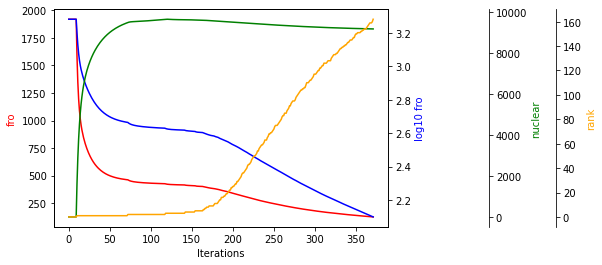

time elasped:  895  s
-------------------------- Validating the training with data  8  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  228700  Ratio:  0.7481264127551137  Off by one:  304627  Ratio:  0.9964998020916136  L2: 0.0738481126199628
Validation with other samples:
Sample size:  2751273  Correct:  715290  Ratio:  0.25998510507681355  Off by one:  1822299  Ratio:  0.6623475751043244  L2: 0.2428850676162785
-------------------------- Running with data  9  --------------------------
Training:
Step size:  4
Tau: 15000
fro:  1921.8140518791095     nuc: 0.0      last rank: 0
fro:  1921.8140518791095     nuc: 0.0      last rank: 0
fro:  1921.8140518791095     nuc: 0.0      last rank: 0
fro:  1921.8140518791095     nuc: 0.0      last rank: 0
fro:  1921.8140518791095     nuc: 0.0      last rank: 0
fro:  1921.8140518791095     nuc: 0.0      last rank: 0
fro:  1921.8140518791095     nuc: 0.0      last rank: 0
fro:  1921.8140518791095     nuc: 0.

fro:  426.96299011898384     nuc: 9630.096838275549      last rank: 2
fro:  426.7177245023852     nuc: 9633.589470111128      last rank: 2
fro:  426.480632031492     nuc: 9637.072208954265      last rank: 2
fro:  426.2514571525901     nuc: 9640.543186473336      last rank: 2
fro:  426.0299659993002     nuc: 9644.000830197245      last rank: 2
fro:  425.8159447746009     nuc: 9647.443843402572      last rank: 2
fro:  424.2987733510252     nuc: 9650.871189386948      last rank: 3
fro:  422.8673758200037     nuc: 9652.614960655912      last rank: 3
fro:  421.78726796185117     nuc: 9652.77926941145      last rank: 3
fro:  420.9467908154653     nuc: 9651.884159912039      last rank: 3
fro:  420.27225966083193     nuc: 9650.312393560074      last rank: 3
fro:  419.71472957593016     nuc: 9648.342957907316      last rank: 3
fro:  419.24138621101565     nuc: 9646.176813692542      last rank: 3
fro:  418.8299678567613     nuc: 9643.956574406537      last rank: 3
fro:  418.4651550342089     nuc

fro:  278.33312499522543     nuc: 9431.621847590766      last rank: 54
fro:  276.2934660756886     nuc: 9428.929957141114      last rank: 55
fro:  274.46097685798026     nuc: 9426.16550358542      last rank: 56
fro:  272.6878966821184     nuc: 9423.44189616423      last rank: 57
fro:  270.9035687925605     nuc: 9420.753748072912      last rank: 58
fro:  269.1588266286521     nuc: 9418.07307109846      last rank: 59
fro:  267.3435131426285     nuc: 9415.408344074342      last rank: 60
fro:  265.684591421022     nuc: 9412.710968700594      last rank: 61
fro:  263.87129449075474     nuc: 9410.07599450642      last rank: 62
fro:  262.0884438468554     nuc: 9407.40111440354      last rank: 63
fro:  260.31445401063354     nuc: 9404.726384060912      last rank: 64
fro:  258.7104172494919     nuc: 9402.059211203148      last rank: 65
fro:  257.10426163527416     nuc: 9399.46575775769      last rank: 66
fro:  255.5210503928971     nuc: 9396.894585901766      last rank: 66
fro:  253.946225262548

fro:  142.15714978086987     nuc: 9212.880631173346      last rank: 146
fro:  141.43005678195664     nuc: 9211.735434234728      last rank: 146
fro:  140.72607901874377     nuc: 9210.602050640617      last rank: 147
fro:  140.02300682728023     nuc: 9209.488596324703      last rank: 147
fro:  139.30130486007312     nuc: 9208.380904899263      last rank: 148
fro:  138.61044574066375     nuc: 9207.269459109688      last rank: 149
fro:  137.92058043598436     nuc: 9206.178735803369      last rank: 149
fro:  137.21235871183038     nuc: 9205.09082624934      last rank: 151
fro:  136.48475241706728     nuc: 9203.998844812573      last rank: 151
fro:  135.76782178582081     nuc: 9202.897874403789      last rank: 152
fro:  135.09266064482682     nuc: 9201.80417009092      last rank: 152
fro:  134.43563572698628     nuc: 9200.734359138918      last rank: 153
fro:  133.77221939131692     nuc: 9199.68109671873      last rank: 153
fro:  133.15208092511733     nuc: 9198.628798527636      last rank:

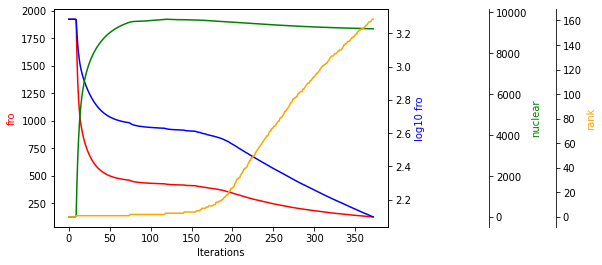

time elasped:  897  s
-------------------------- Validating the training with data  9  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  229182  Ratio:  0.7497031374203869  Off by one:  304660  Ratio:  0.9966077521205639  L2: 0.07347834027242221
Validation with other samples:
Sample size:  2751273  Correct:  715712  Ratio:  0.26013848861963174  Off by one:  1823842  Ratio:  0.6629084063995103  L2: 0.2428921541610375
--------------------------------- Summary ---------------------------------
-------------------------- Data  0  --------------------------
Validation with training sample:
Sample size:  305697  Correct:  229025  Ratio:  0.7491895569796236  Off by one:  304630  Ratio:  0.996509615730609  L2: 0.07371904903673013
Validation with other samples:
Sample size:  2751273  Correct:  713284  Ratio:  0.25925598804626077  Off by one:  1821198  Ratio:  0.6619473967141756  L2: 0.24300401647843456
-------------------------- Data  1  ---------------

In [5]:
import svt
import utils
import time
import scipy
import scipy.sparse
import scipy.sparse.linalg

# returns the size of the locations, the number of correct predicted values,
# the number of predicted values off by one (means off by 0.5 in ratings),
# and the Frobenius norm squared of the error matrix and original matrix on these locations
def validate_training_result(prediction, actual, locations):
    correct = 0
    off_by_one = 0
    for j in range(len(locations[0])):
        predicted_value = prediction[locations[0][j], locations[1][j]]
        actual_value = actual[locations[0][j], locations[1][j]]
        if predicted_value == actual_value:
            correct += 1
        if abs(predicted_value - actual_value) <= 1:
            off_by_one += 1
    difference = utils.filter_locations( (prediction - actual).astype(dtype="float32"), locations)
    fro_squared = scipy.sparse.linalg.norm(difference, ord='fro')
    fro_squared = fro_squared * fro_squared
    original_fro_squared = scipy.sparse.linalg.norm(utils.filter_locations(actual.astype("float32"), locations), ord='fro')
    original_fro_squared = original_fro_squared * original_fro_squared
    return len(locations[0]), correct, off_by_one, fro_squared, original_fro_squared

# obtain matrix with all the available data in 3000x3000 users and movies.
total_ratings_pivot = ratingsS.pivot(index = "userId", columns = "movieId", values = "rating")
total_ratings_matrix = total_ratings_pivot.to_numpy(copy=True, na_value = np.nan)
total_ratings_matrix_int = np.rint(total_ratings_matrix * 2).astype("int32")

# performance data for cross validation
train_total_no = []
train_correct = []
train_off_by_one = []
train_fro_norm_relative = []
valid_total_no = []
valid_correct = []
valid_off_by_one = []
valid_fro_norm_relative = []

# do cross validation here
for k in range(divisions):
    print("-------------------------- Running with data ", k, " --------------------------")
    print("Training:")
    movie_arr = ratingsSubsamplePivot[k].to_numpy(copy=True, na_value = np.nan)
    
    # obtain the locations of a subsample
    locations = ratingsSubsample[k][["uid_matrix","mid_matrix"]].to_numpy(dtype=int, copy=True).transpose()
    locations = locations.tolist()
    # convert to sparse matrix
    movie_arr = utils.filter_locations(movie_arr, locations) 
    
    # run SVT using the sparse matrix
    timems = time.time()
    result = svt.svt_algorithm_small_step_size(movie_arr, locations, log=True, step_size = 4, tolerance = 125, tolerance_absolute = True) #, suggested_tau = 30000
    print("time elasped: ",int(time.time()-timems)," s")
    
    # predict using result
    predict = np.rint(result * 2) / 2.0
    predict = np.maximum(np.minimum(predict, 5.0), 1.0) # truncating if too large/small
    
    # validation step
    print("-------------------------- Validating the training with data ", k, " --------------------------")
    intpredict = (np.rint(predict * 2)).astype("int32")
    total_no, total_correct, total_off_by_one, total_fro_norm_sq, original_fro_norm_sq = validate_training_result(intpredict, total_ratings_matrix_int, locations)
    relative_fro_norm = math.sqrt(total_fro_norm_sq / original_fro_norm_sq)
    print("Validation with training sample:")
    print("Sample size: ", total_no, " Correct: ", total_correct, " Ratio: ", (total_correct+0.0)/total_no, " Off by one: ", total_off_by_one, " Ratio: ", (total_off_by_one+0.0)/total_no, " L2:", relative_fro_norm)
    train_total_no.append(total_no)
    train_correct.append(total_correct)
    train_off_by_one.append(total_off_by_one)
    train_fro_norm_relative.append(relative_fro_norm)
    
    print("Validation with other samples:")
    total_no = 0
    total_correct = 0
    total_off_by_one = 0
    total_fro_norm_sq = 0
    original_fro_norm_sq = 0
    for j in range(divisions):
        if j != k:
            jlocations = ratingsSubsample[j][["uid_matrix","mid_matrix"]].to_numpy(dtype=int, copy=True).transpose()
            jlocations = jlocations.tolist()

            jtotal_no, jtotal_correct, joff_by_one, jfro_norm_sq, joriginal_fro_norm = validate_training_result(intpredict, total_ratings_matrix_int, jlocations)
            total_no += jtotal_no
            total_correct += jtotal_correct
            total_off_by_one += joff_by_one
            total_fro_norm_sq += jfro_norm_sq
            original_fro_norm_sq += joriginal_fro_norm
    relative_fro_norm = math.sqrt(total_fro_norm_sq / original_fro_norm_sq)
    print("Sample size: ", total_no, " Correct: ", total_correct, " Ratio: ", (total_correct+0.0)/total_no, " Off by one: ", total_off_by_one, " Ratio: ", (total_off_by_one+0.0)/total_no, " L2:", relative_fro_norm)
    valid_total_no.append(total_no)
    valid_correct.append(total_correct)
    valid_off_by_one.append(total_off_by_one)
    valid_fro_norm_relative.append(relative_fro_norm)

print("--------------------------------- Summary ---------------------------------")
for k in range(divisions):
    print("-------------------------- Data ", k, " --------------------------")
    total_no = train_total_no[k]
    total_correct = train_correct[k]
    total_off_by_one = train_off_by_one[k]
    relative_fro_norm = train_fro_norm_relative[k]
    print("Validation with training sample:")
    print("Sample size: ", total_no, " Correct: ", total_correct, " Ratio: ", (total_correct+0.0)/total_no, " Off by one: ", total_off_by_one, " Ratio: ", (total_off_by_one+0.0)/total_no, " L2:", relative_fro_norm)
    total_no = valid_total_no[k]
    total_correct = valid_correct[k]
    total_off_by_one = valid_off_by_one[k]
    relative_fro_norm = valid_fro_norm_relative[k]
    print("Validation with other samples:")
    print("Sample size: ", total_no, " Correct: ", total_correct, " Ratio: ", (total_correct+0.0)/total_no, " Off by one: ", total_off_by_one, " Ratio: ", (total_off_by_one+0.0)/total_no, " L2:", relative_fro_norm)